In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from itertools import product
from collections import defaultdict

from IPython.display import display
import time

In [315]:
def finding_days_users_less_than_2hrs_records_groupto(df):
    all_users_days_df = df.copy()
    all_users_days_df['date'] = all_users_days_df.apply(lambda x : x.cleaned_UTC_time.date(), axis=1)
    all_users_unique_days_df = all_users_days_df.groupby('user_id')['date'].nunique().reset_index(name='counts')
    all_users_unique_days_df = all_users_unique_days_df.sort_values(by=['counts'])
    return all_users_unique_days_df

## PrefixSpan experiments for the 10 categories

In [316]:
new_nyc_df = pd.read_csv('cleaned_NYC_records_original_updated_duration.csv')
new_nyc_df['cleaned_UTC_time'] = pd.to_datetime(new_nyc_df["UTC_time"])
less_equal_2hours_df = new_nyc_df[(new_nyc_df.duration <= 2) & (new_nyc_df.duration != -1)]

months = [4, 5, 6]
less_than_2hrs_3months_df = less_equal_2hours_df.copy()
less_than_2hrs_3months_df['month'] = less_than_2hrs_3months_df['cleaned_UTC_time'].dt.month
less_than_2hrs_3months_df = less_than_2hrs_3months_df[less_than_2hrs_3months_df['month'].isin(months)]

In [317]:
user_days_df = finding_days_users_less_than_2hrs_records_groupto(less_than_2hrs_3months_df)
frequent_users_df = user_days_df[user_days_df['counts'] >= 50]

In [318]:
user_set_df = less_than_2hrs_3months_df[less_than_2hrs_3months_df.user_id.isin(frequent_users_df.user_id)]

In [320]:
user_set_df_count = user_set_df.groupby(['user_id']).size().reset_index(name='counts')
user_set_df_count.describe()

,user_id,counts
count,34.000000,34.000000
mean,494.352941,274.500000
std,273.990697,145.559579
min,84.000000,74.000000
25%,284.000000,158.750000
50%,441.500000,240.500000
75%,701.750000,344.000000
max,990.000000,629.000000


In [85]:
user_set_df = less_than_2hrs_3months_df[less_than_2hrs_3months_df.user_id.isin(frequent_users_df.user_id)]

# Eateries - E
# Others - O
# Outdoors - Out
# Education - Edu
# Shops - Sh
# Arts - A
# Services - Ser
# Religious Places - R
# Entertainment - Ent
# Exhibitions - Ex
# Fitness - F



general_categories_tags_dict = {
        'Eateries': 'E', 
        'Others': 'O',
        'Outdoor': 'Out',
        'Education': 'Edu',
        'Shops': 'Sh',
        'Arts': 'A',
        'Services': 'Ser',
        'Religious Places': 'R',
        'Entertainment': 'Ent',
        'Exhibitions': 'Ex',
        'Fitness': 'F'
    }

def generate_general_categories_tags(row):
    return general_categories_tags_dict[row['general_venue_category_name']]

user_set_df['general_venue_category_tag'] = user_set_df.apply(generate_general_categories_tags, axis=1)

<ipython-input-85-dc382168d01a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_set_df['general_venue_category_tag'] = user_set_df.apply(generate_general_categories_tags, axis=1)


In [86]:
subsequence_all_df = user_set_df.copy()
subsequence_all_df['date'] = subsequence_all_df.apply(lambda x : x.cleaned_UTC_time.date(), axis=1)
subsequence_all_df = subsequence_all_df.groupby(['user_id', 'date'])['general_venue_category_tag'].apply(lambda x: list(x)).reset_index(name='category_set')
subsequence_all_df['counts'] = subsequence_all_df['category_set'].apply(lambda x: len(x))

In [9]:
def mine_rec(patt, mdb, db, results, minsup):
    def localOccurs(mdb):
        occurs = defaultdict(list)

        # The stoppos is always start with 1, and 1 represents the 0th index element in the sequence
        for (i, stoppos) in mdb:
            seq = db[i]
            for j in range(stoppos, len(seq)):
                l = occurs[seq[j]]
                if len(l) == 0 or l[-1][0] != i:
                    l.append((i, j + 1))

        return occurs

    for (c, newmdb) in localOccurs(mdb).items():
        newsup = len(newmdb)

        if newsup >= minsup:
            newpatt = patt + [c]

            results.append((newpatt, [i for (i, stoppos) in newmdb]))
            mine_rec(newpatt, newmdb, db, results, minsup)
            
def mine_specific_user_rec(df, user_id, support_percentage):
    db = np.array(df[(df.user_id == user_id)].category_set)
    minsup = np.floor(len(db) * support_percentage)
    results = []
    
    mine_rec([], [(i, 0) for i in range(len(db))], db, results, minsup)
    return results

In [9]:
results_178 = mine_specific_user_rec(subsequence_all_df, 178)
result_178 = [{'sequence': i[0], 'length': len(i[0]) , 'support': len(i[1])} for i in results_178]
result_178

[{'sequence': ['E'], 'length': 1, 'support': 43},
 {'sequence': ['E', 'E'], 'length': 2, 'support': 28},
 {'sequence': ['E', 'Sh'], 'length': 2, 'support': 27},
 {'sequence': ['Sh'], 'length': 1, 'support': 38},
 {'sequence': ['Sh', 'O'], 'length': 2, 'support': 28},
 {'sequence': ['O'], 'length': 1, 'support': 37}]

In [15]:
results_962 = mine_specific_user_rec(subsequence_all_df, 962)
result_962 = [{'sequence': i[0], 'length': len(i[0]) , 'support': len(i[1])} for i in results_962]
result_962

[{'sequence': ['O'], 'length': 1, 'support': 39}]

In [16]:
results_185 = mine_specific_user_rec(subsequence_all_df, 185)
result_185 = [{'sequence': i[0], 'length': len(i[0]) , 'support': len(i[1])} for i in results_185]
result_185

[{'sequence': ['E'], 'length': 1, 'support': 63},
 {'sequence': ['E', 'E'], 'length': 2, 'support': 50},
 {'sequence': ['E', 'Ser'], 'length': 2, 'support': 42},
 {'sequence': ['O'], 'length': 1, 'support': 42},
 {'sequence': ['Ser'], 'length': 1, 'support': 51},
 {'sequence': ['Out'], 'length': 1, 'support': 38},
 {'sequence': ['Ent'], 'length': 1, 'support': 40}]

## PrefixSpan experiments for 13 categories

In [87]:
new_nyc_df = pd.read_csv('cleaned_NYC_records_13_categories_updated_duration.csv')
new_nyc_df['cleaned_UTC_time'] = pd.to_datetime(new_nyc_df["UTC_time"])
less_equal_2hours_df = new_nyc_df[(new_nyc_df.duration <= 2) & (new_nyc_df.duration != -1)]

months = [4, 5, 6]
less_than_2hrs_3months_df = less_equal_2hours_df.copy()
less_than_2hrs_3months_df['month'] = less_than_2hrs_3months_df['cleaned_UTC_time'].dt.month
less_than_2hrs_3months_df = less_than_2hrs_3months_df[less_than_2hrs_3months_df['month'].isin(months)]

In [88]:
user_days_df = finding_days_users_less_than_2hrs_records_groupto(less_than_2hrs_3months_df)
frequent_users_df = user_days_df[user_days_df['counts'] >= 50]

In [89]:
user_set_df = less_than_2hrs_3months_df[less_than_2hrs_3months_df.user_id.isin(frequent_users_df.user_id)]

# Eateries - E
# Cafe/Desserts - CD
# Drinking place - D
# Indoor Exhibitions - InEx
# Outdoor Exhibitions - OutEx
# Regligious Places - R
# Shops - Sh
# Services - Ser
# Education - Edu
# Arts - A
# Outdoor - Out
# Entertainment - Ent
# Fitness - F
# Others - O

general_categories_tags_dict = {
        'Eateries': 'E',
        'Cafe/Desserts': 'CD',
        'Drinking place': 'D',
        'Indoor Exhibitions': 'InEx',
        'Outdoor Exhibitions': 'OutEx',
        'Religious Places': 'R',
        'Shops': 'Sh',
        'Services': 'Ser',
        'Education': 'Edu',
        'Arts': 'A',
        'Outdoor': 'Out',
        'Entertainment': 'Ent',
        'Fitness': 'F',
        'Others': 'O'
    }

def generate_general_categories_tags(row):
    return general_categories_tags_dict[row['general_venue_category_name']]

user_set_df['general_venue_category_tag'] = user_set_df.apply(generate_general_categories_tags, axis=1)

<ipython-input-89-dd4609bd6c02>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_set_df['general_venue_category_tag'] = user_set_df.apply(generate_general_categories_tags, axis=1)


In [90]:
subsequence_all_13categories_df = user_set_df.copy()
subsequence_all_13categories_df['date'] = subsequence_all_13categories_df.apply(lambda x : x.cleaned_UTC_time.date(), axis=1)
subsequence_all_13categories_df = subsequence_all_13categories_df.groupby(['user_id', 'date'])['general_venue_category_tag'].apply(lambda x: list(x)).reset_index(name='category_set')
subsequence_all_13categories_df['counts'] = subsequence_all_13categories_df['category_set'].apply(lambda x: len(x))

In [14]:
results_178 = mine_specific_user_rec(subsequence_all_13categories_df, 178)
result_178 = [{'sequence': i[0], 'length': len(i[0]),'support': len(i[1])} for i in results_178]
result_178

[{'sequence': ['E'], 'length': 1, 'support': 38},
 {'sequence': ['Sh'], 'length': 1, 'support': 38},
 {'sequence': ['Sh', 'O'], 'length': 2, 'support': 28},
 {'sequence': ['O'], 'length': 1, 'support': 37}]

In [17]:
results_962 = mine_specific_user_rec(subsequence_all_13categories_df, 962)
result_962 = [{'sequence': i[0], 'length': len(i[0]) , 'support': len(i[1])} for i in results_962]
result_962

[{'sequence': ['O'], 'length': 1, 'support': 39}]

In [18]:
results_185 = mine_specific_user_rec(subsequence_all_13categories_df, 185)
result_185 = [{'sequence': i[0], 'length': len(i[0]) , 'support': len(i[1])} for i in results_185]
result_185

[{'sequence': ['D'], 'length': 1, 'support': 49},
 {'sequence': ['E'], 'length': 1, 'support': 53},
 {'sequence': ['O'], 'length': 1, 'support': 42},
 {'sequence': ['Ser'], 'length': 1, 'support': 51},
 {'sequence': ['Out'], 'length': 1, 'support': 38},
 {'sequence': ['Ent'], 'length': 1, 'support': 40}]

## PrefixSpan experiment for 7 categories

In [4]:
new_nyc_df = pd.read_csv('cleaned_NYC_records_7_categories_updated_duration.csv')
new_nyc_df['cleaned_UTC_time'] = pd.to_datetime(new_nyc_df["UTC_time"])
less_equal_2hours_df = new_nyc_df[(new_nyc_df.duration <= 2) & (new_nyc_df.duration != -1)]

months = [4, 5, 6]
less_than_2hrs_3months_df = less_equal_2hours_df.copy()
less_than_2hrs_3months_df['month'] = less_than_2hrs_3months_df['cleaned_UTC_time'].dt.month
less_than_2hrs_3months_df = less_than_2hrs_3months_df[less_than_2hrs_3months_df['month'].isin(months)]

In [5]:
user_days_df = finding_days_users_less_than_2hrs_records_groupto(less_than_2hrs_3months_df)
frequent_users_df = user_days_df[user_days_df['counts'] >= 50]

In [6]:
user_set_df = less_than_2hrs_3months_df[less_than_2hrs_3months_df.user_id.isin(frequent_users_df.user_id)]

# E, O, Out, Edu(Edu, R), Sh(Sh, Ser), Ent(A, Ex, Ent), F

# Eateries - E
# Shops - Sh
# Education - Edu
# Outdoor - Out
# Entertainment - Ent
# Fitness - F
# Others - O

general_categories_tags_dict = {
        'Eateries': 'E',
        'Shops': 'Sh',
        'Education': 'Edu',
        'Outdoor': 'Out',
        'Entertainment': 'Ent',
        'Fitness': 'F',
        'Others': 'O'
    }

def generate_general_categories_tags(row):
    return general_categories_tags_dict[row['general_venue_category_name']]

user_set_df['general_venue_category_tag'] = user_set_df.apply(generate_general_categories_tags, axis=1)

<ipython-input-6-e5a712da17ab>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_set_df['general_venue_category_tag'] = user_set_df.apply(generate_general_categories_tags, axis=1)


In [7]:
subsequence_all_7categories_df = user_set_df.copy()
subsequence_all_7categories_df['date'] = subsequence_all_7categories_df.apply(lambda x : x.cleaned_UTC_time.date(), axis=1)
subsequence_all_7categories_df = subsequence_all_7categories_df.groupby(['user_id', 'date'])['general_venue_category_tag'].apply(lambda x: list(x)).reset_index(name='category_set')
subsequence_all_7categories_df['counts'] = subsequence_all_7categories_df['category_set'].apply(lambda x: len(x))

In [11]:
results_178 = mine_specific_user_rec(subsequence_all_7categories_df, 178, 0.5)
result_178 = [{'sequence': i[0], 'length': len(i[0]),'support': len(i[1])} for i in results_178]
result_178

[{'sequence': ['E'], 'length': 1, 'support': 43},
 {'sequence': ['E', 'E'], 'length': 2, 'support': 28},
 {'sequence': ['E', 'Sh'], 'length': 2, 'support': 27},
 {'sequence': ['Sh'], 'length': 1, 'support': 40},
 {'sequence': ['Sh', 'O'], 'length': 2, 'support': 29},
 {'sequence': ['O'], 'length': 1, 'support': 37}]

In [24]:
results_962 = mine_specific_user_rec(subsequence_all_7categories_df, 962)
result_962 = [{'sequence': i[0], 'length': len(i[0]) , 'support': len(i[1])} for i in results_962]
result_962

[{'sequence': ['O'], 'length': 1, 'support': 39}]

In [25]:
results_185 = mine_specific_user_rec(subsequence_all_7categories_df, 185)
result_185 = [{'sequence': i[0], 'length': len(i[0]) , 'support': len(i[1])} for i in results_185]
result_185

[{'sequence': ['E'], 'length': 1, 'support': 63},
 {'sequence': ['E', 'E'], 'length': 2, 'support': 50},
 {'sequence': ['E', 'Ent'], 'length': 2, 'support': 41},
 {'sequence': ['E', 'Sh'], 'length': 2, 'support': 42},
 {'sequence': ['Ent'], 'length': 1, 'support': 48},
 {'sequence': ['Ent', 'E'], 'length': 2, 'support': 37},
 {'sequence': ['O'], 'length': 1, 'support': 42},
 {'sequence': ['Sh'], 'length': 1, 'support': 52},
 {'sequence': ['Out'], 'length': 1, 'support': 38}]

## Statistics of different number of categories

In [24]:
def calculating_number_of_sequences_found(df, frequent_users_df, support_percentage):
    result_df = pd.DataFrame(columns=['user_id', 'number_of_sequences'])
    
    for user_id in frequent_users_df.user_id:
        user_df = pd.DataFrame(columns=['sequence', 'length', 'support'])
        user_result_df = mine_specific_user_rec(df, user_id, support_percentage)
        
        for i in user_result_df:
            user_new_record_row = {'sequence': i[0], 'length': len(i[0]), 'support': len(i[1])}
            user_df = user_df.append(user_new_record_row, ignore_index=True)
            
        if np.isnan(user_df.length.mean()):
            avg_length = 0
        else:
            avg_length = user_df.length.mean()
            
        if np.isnan(user_df.support.mean()):
            avg_support = 0
        else:
            avg_support = user_df.support.mean()
            
        new_row = {'user_id': user_id, 'number_of_sequences': user_df.shape[0], 'avg_length': avg_length,
                   'avg_support': avg_support}
        result_df = result_df.append(new_row, ignore_index=True)
    return result_df

### For 7 categories

In [56]:
result_df_7_categories = calculating_number_of_sequences_found(subsequence_all_7categories_df, frequent_users_df)

result_df_7_categories['number_of_sequences'] = result_df_7_categories['number_of_sequences'].astype(int)
result_df_7_categories.describe()

,user_id,number_of_sequences,avg_length,avg_support
count,34.000000,34.000000,34.000000,34.000000
mean,494.352941,5.823529,1.478853,40.332424
std,273.990697,7.329767,0.517141,6.395292
min,84.000000,1.000000,1.000000,32.030303
25%,284.000000,2.250000,1.000000,35.181818
50%,441.500000,4.000000,1.333333,39.000000
75%,701.750000,6.000000,1.670455,45.666667
max,990.000000,33.000000,3.060606,57.000000


### For 10 categories

In [57]:
result_df_10_categories = calculating_number_of_sequences_found(subsequence_all_df, frequent_users_df)

result_df_10_categories['number_of_sequences'] = result_df_10_categories['number_of_sequences'].astype(int)
result_df_10_categories.describe()

,user_id,number_of_sequences,avg_length,avg_support
count,34.000000,34.000000,34.000000,34.000000
mean,494.352941,4.852941,1.439510,40.726457
std,273.990697,5.147122,0.493587,6.399494
min,84.000000,1.000000,1.000000,32.500000
25%,284.000000,2.000000,1.000000,35.178571
50%,441.500000,3.000000,1.333333,39.750000
75%,701.750000,6.000000,1.575000,45.600000
max,990.000000,25.000000,2.714286,57.000000


### For 13 categories

In [58]:
result_df_13_categories = calculating_number_of_sequences_found(subsequence_all_13categories_df, frequent_users_df)

result_df_13_categories['number_of_sequences'] = result_df_13_categories['number_of_sequences'].astype(int)
result_df_13_categories.describe()

,user_id,number_of_sequences,avg_length,avg_support
count,34.000000,34.000000,34.000000,34.000000
mean,494.352941,4.235294,1.381373,40.279657
std,273.990697,4.015567,0.446319,6.728839
min,84.000000,1.000000,1.000000,28.500000
25%,284.000000,2.000000,1.000000,34.375000
50%,441.500000,3.000000,1.291667,40.166667
75%,701.750000,5.750000,1.500000,44.833333
max,990.000000,20.000000,2.350000,57.000000


## Global clock implementation

In [142]:
def global_clock_implementation(number_of_categories, user_id, support_percentage):
    if number_of_categories == 7:
        user_seq_results = mine_specific_user_rec(subsequence_all_7categories_df, user_id, support_percentage)
    elif number_of_categories == 10:
        user_seq_results = mine_specific_user_rec(subsequence_all_df, user_id, support_percentage)
    else:
        user_seq_results = mine_specific_user_rec(subsequence_all_13categories_df, user_id, support_percentage)
        
    max_length = 0
    for i in user_seq_results:
        if len(i[0]) > max_length:
            max_length = len(i[0])
        
    user_seq_record = [{} for i in range(max_length)]
    
    for i in user_seq_results:
        for j in range(len(i[0])):
            if len(i[0]) >= j:
                key = i[0][j]
                if key not in user_seq_record[j]:
                    user_seq_record[j][key] = len(i[1])
                else:
                    user_seq_record[j][key] = user_seq_record[j][key] + len(i[1])
    
    for i in range(len(user_seq_record)):
        total_frequencies = sum(user_seq_record[i].values())
        for k, v in user_seq_record[i].items():
             user_seq_record[i][k] = round(v / total_frequencies, 2)
            
    return user_seq_record
    

In [4]:
import json
import ast
import csv

In [5]:
## To encode the probabilistic patterns
def encode_probabilistic_patterns(patterns_list, patterns_file):
    f = open(patterns_file, 'w', newline='')

    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    for pattern in patterns_list:
        values_str = [json.dumps(i) for i in pattern]
        writer.writerow(values_str)

    # close the file
    f.close()

## To decode the probabilistic patterns
def decode_probabilistic_patterns(patterns_file):
    patterns_list = []
    
    f = open(patterns_file, 'r')
    
    reader = csv.reader(f)
    
    for row in reader:
        values = [ast.literal_eval(i) for i in row]
        
        if len(values) > 0:
            patterns_list.append(values)
        
    f.close()
    
    return patterns_list

In [198]:
def write_probabilistic_patterns_csv(number_of_categories, support_threshold):
    patterns_list = []
    
    for user_id in frequent_users_df.user_id:
        patterns_list.append(global_clock_implementation(number_of_categories, user_id, support_threshold))
        
    encode_probabilistic_patterns(patterns_list, "{}_{}_probabilistic_patterns.csv".format(support_threshold, number_of_categories))

### For 7 categories

In [207]:
write_probabilistic_patterns_csv(7, 0.5)

In [209]:
patterns_list = decode_probabilistic_patterns("0.5_7_probabilistic_patterns.csv")
print(patterns_list)

[[{'O': 0.76, 'E': 0.24}, {'O': 0.68, 'E': 0.32}, {'O': 0.67, 'E': 0.33}], [{'O': 0.34, 'E': 0.48, 'Sh': 0.18}, {'E': 0.47, 'O': 0.31, 'Sh': 0.22}, {'O': 0.34, 'E': 0.43, 'Sh': 0.23}, {'O': 0.33, 'E': 0.67}], [{'Sh': 0.51, 'O': 0.49}, {'O': 1.0}], [{'Out': 0.33, 'O': 0.67}, {'O': 0.8, 'Out': 0.2}, {'O': 1.0}], [{'E': 1.0}, {'E': 1.0}, {'E': 1.0}], [{'Sh': 0.38, 'E': 0.32, 'Edu': 0.3}], [{'O': 0.77, 'Sh': 0.23}, {'O': 1.0}], [{'O': 0.49, 'Sh': 0.51}], [{'E': 0.57, 'O': 0.43}], [{'O': 1.0}], [{'O': 1.0}], [{'E': 0.53, 'O': 0.47}], [{'E': 0.48, 'Sh': 0.34, 'O': 0.18}, {'E': 0.33, 'Sh': 0.32, 'O': 0.35}], [{'Sh': 0.51, 'E': 0.49}], [{'E': 0.55, 'Sh': 0.21, 'O': 0.24}, {'Sh': 0.21, 'E': 0.67, 'O': 0.12}, {'E': 0.72, 'Sh': 0.24, 'O': 0.04}, {'E': 0.82, 'Sh': 0.18}, {'E': 0.81, 'Sh': 0.19}, {'E': 1.0}], [{'O': 0.44, 'E': 0.56}], [{'O': 0.38, 'Sh': 0.19, 'Out': 0.22, 'E': 0.21}, {'E': 1.0}], [{'O': 1.0}], [{'Sh': 0.86, 'O': 0.14}, {'Sh': 0.8, 'O': 0.2}, {'Sh': 1.0}, {'Sh': 1.0}], [{'E': 0.26, 

### For 10 categories

In [133]:
global_clock_implementation(10, 178, 0.5)

[{'E': 0.49, 'Sh': 0.33, 'O': 0.18}, {'E': 0.34, 'Sh': 0.33, 'O': 0.34}]


### For 13 categories

In [134]:
global_clock_implementation(13, 178, 0.5)

[{'E': 0.27, 'Sh': 0.47, 'O': 0.26}, {'O': 1.0}]


In [210]:
write_probabilistic_patterns_csv(14, 0.5)

## Experiment 1 (Threshold vs number of sequences): 

In [82]:
def prefixSpan_threshold_change(number_of_category):
    thresholds = [0.25, 0.5, 0.75]
    number_of_sequences = []
    length = []
    
#     intermediate_list = []
    
    if number_of_category == 7:
        df = subsequence_all_7categories_df
    elif number_of_category == 10:
        df = subsequence_all_df
    else:
        df = subsequence_all_13categories_df
    
    for threshold in thresholds:
#         print(threshold)
        result_df = calculating_number_of_sequences_found(df, frequent_users_df, threshold)
#         length = user_mean_df['number_of_sequences'].size
#         thres = [threshold] * length
        result_df['number_of_sequences'] = result_df['number_of_sequences'].astype(int)
        number_of_sequences.append(result_df['number_of_sequences'].mean())
        
        result_df['avg_length'] = result_df['avg_length'].astype(int)
        length.append(result_df['avg_length'].mean())
    
    return thresholds, number_of_sequences, length
#         result_df = user_mean_df[['number_of_sequences', 'avg_length', 'avg_support']]
#         intermediate = result_df.values.tolist()
        
#         for i in range(len(intermediate)):
#             intermediate[i].append(threshold)
#             intermediate_list.append(intermediate[i])
            
#     res = pd.DataFrame(intermediate_list, columns=['number_of_sequences', 'avg_length', 'avg_support', 'threshold'])
#     return res

### 7 categories

In [95]:
res_7 = prefixSpan_threshold_change(7)

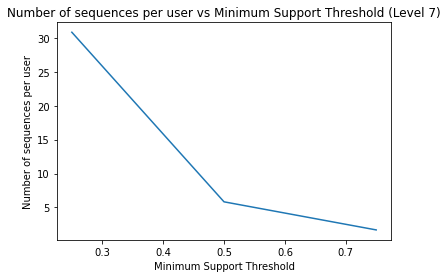

In [602]:
plt.plot(res_7[0], res_7[1])
plt.xlabel('Minimum Support Threshold')
plt.ylabel('Number of sequences per user')
plt.title('Number of sequences per user vs Minimum Support Threshold (Level 7)')
plt.show()

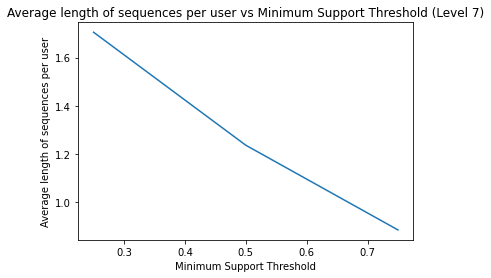

In [603]:
plt.plot(res_7[0], res_7[2])
plt.xlabel('Minimum Support Threshold')
plt.ylabel('Average length of sequences per user')
plt.title('Average length of sequences per user vs Minimum Support Threshold (Level 7)')
plt.show()

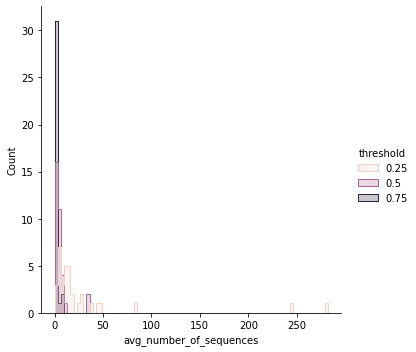

In [81]:
sns.displot(res, x="avg_number_of_sequences", hue="threshold", element="step")

## 10 categories

In [101]:
res_10 = prefixSpan_threshold_change(10)

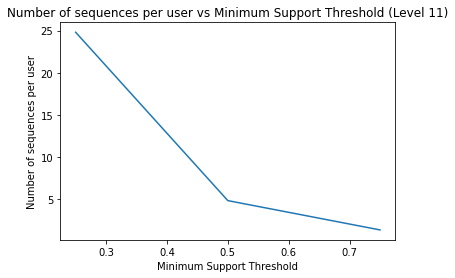

In [604]:
plt.plot(res_10[0], res_10[1])
plt.xlabel('Minimum Support Threshold')
plt.ylabel('Number of sequences per user')
plt.title('Number of sequences per user vs Minimum Support Threshold (Level 11)')
plt.show()

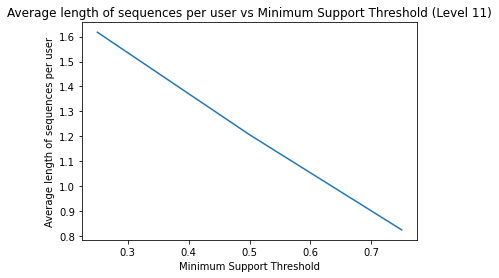

In [605]:
plt.plot(res_10[0], res_10[2])
plt.xlabel('Minimum Support Threshold')
plt.ylabel('Average length of sequences per user')
plt.title('Average length of sequences per user vs Minimum Support Threshold (Level 11)')
plt.show()

## 13 categories

In [106]:
res_13 = prefixSpan_threshold_change(13)

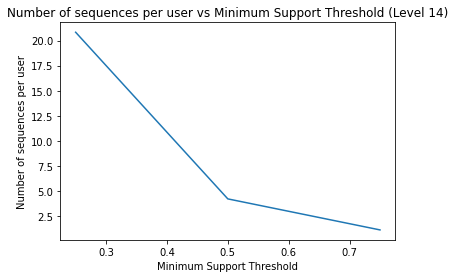

In [606]:
plt.plot(res_13[0], res_13[1])
plt.xlabel('Minimum Support Threshold')
plt.ylabel('Number of sequences per user')
plt.title('Number of sequences per user vs Minimum Support Threshold (Level 14)')
plt.show()

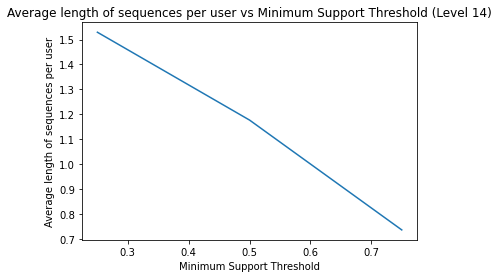

In [610]:
plt.plot(res_13[0], res_13[2])
plt.xlabel('Minimum Support Threshold')
plt.ylabel('Average length of sequences per user')
plt.title('Average length of sequences per user vs Minimum Support Threshold (Level 14)')
plt.show()

### Combining all three level of categories (effect on no_of_sequences and length)

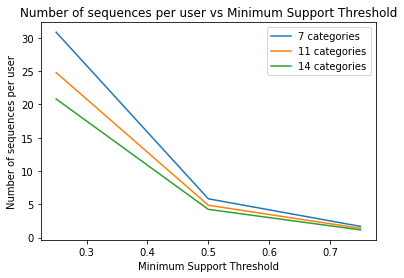

In [607]:
plt.plot(res_7[0], res_7[1], label="7 categories")
plt.plot(res_10[0], res_10[1], label="11 categories")
plt.plot(res_13[0], res_13[1], label="14 categories")
plt.xlabel('Minimum Support Threshold')
plt.ylabel('Number of sequences per user')
plt.title('Number of sequences per user vs Minimum Support Threshold')
plt.legend()
plt.show()

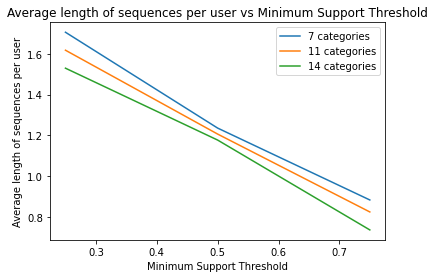

In [609]:
plt.plot(res_7[0], res_7[2], label="7 categories")
plt.plot(res_10[0], res_10[2], label="11 categories")
plt.plot(res_13[0], res_13[2], label="14 categories")
plt.xlabel('Minimum Support Threshold')
plt.ylabel('Average length of sequences per user')
plt.title('Average length of sequences per user vs Minimum Support Threshold')
plt.legend()
plt.show()

## Experiment 2 (Under the same threshold 0.5) Change on the level of categories

In [120]:
def prefixSpan_level_change():
    threshold = 0.5
    levels = [7, 10, 13]
    
    no_of_sequences = []
    no_sequence_7 = []
    no_sequence_10 = []
    no_sequence_13 = []
    
    avg_lengths = []
    avg_length_7 = []
    avg_length_10 = []
    avg_length_13 = []
    
    for level in levels:
        if level == 7:
            df = subsequence_all_7categories_df
            result_df = calculating_number_of_sequences_found(df, frequent_users_df, threshold)
            no_sequence_7.extend(result_df['number_of_sequences'].tolist())
            avg_length_7.extend(result_df['avg_length'].tolist())
        elif level == 10:
            df = subsequence_all_df
            result_df = calculating_number_of_sequences_found(df, frequent_users_df, threshold)
            no_sequence_10.extend(result_df['number_of_sequences'].tolist())
            avg_length_10.extend(result_df['avg_length'].tolist())
        else:
            df = subsequence_all_13categories_df
            result_df = calculating_number_of_sequences_found(df, frequent_users_df, threshold)
            no_sequence_13.extend(result_df['number_of_sequences'].tolist())
            avg_length_13.extend(result_df['avg_length'].tolist())
            
    df_levels = []
    
    df_levels.extend([7] * len(no_sequence_7))
    df_levels.extend([10] * len(no_sequence_10))
    df_levels.extend([13] * len(no_sequence_13))
        
    no_of_sequences.extend(no_sequence_7)
    no_of_sequences.extend(no_sequence_10)
    no_of_sequences.extend(no_sequence_13)
    
    avg_lengths.extend(avg_length_7)
    avg_lengths.extend(avg_length_10)
    avg_lengths.extend(avg_length_13)
    
    d = {'levels': df_levels, 'no_of_sequences': no_of_sequences, 'avg_lengths': avg_lengths}
    
    output = pd.DataFrame(d)
    
    return output

In [121]:
output = prefixSpan_level_change()

Text(0.5, 6.79999999999999, 'Number of sequences')

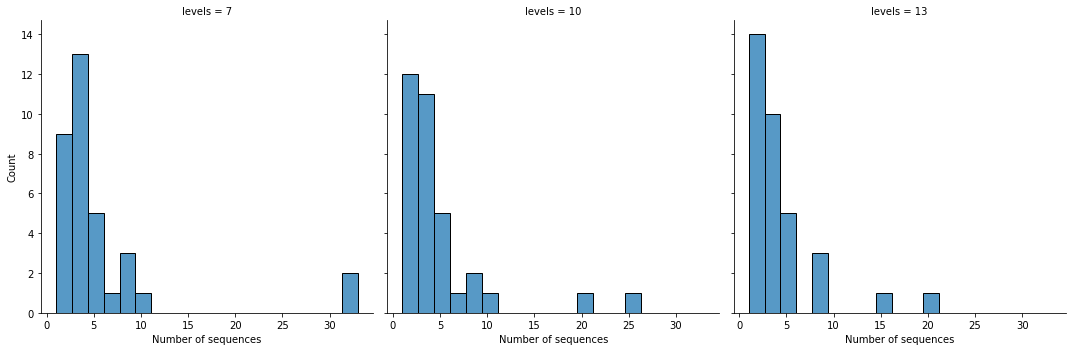

In [445]:
p = sns.displot(output, x="no_of_sequences", col="levels")
p.axes[0,0].set_xlabel('Number of sequences')
p.axes[0,1].set_xlabel('Number of sequences')
p.axes[0,2].set_xlabel('Number of sequences')

Text(0.5, 6.79999999999999, 'Average length')

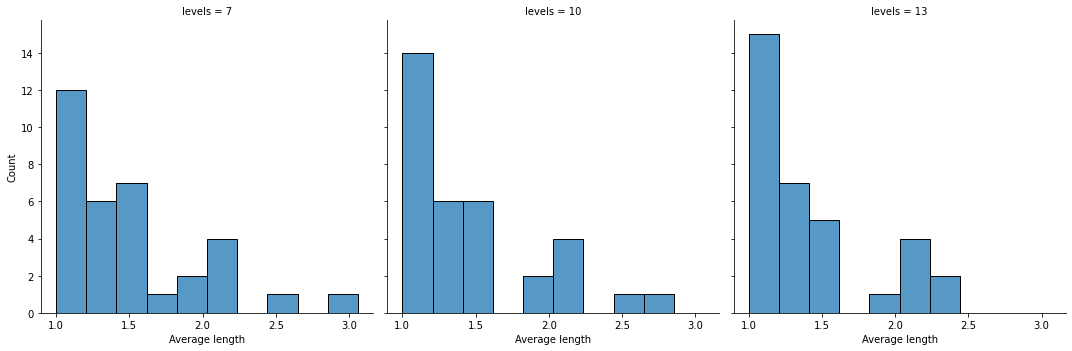

In [444]:
p = sns.displot(output, x="avg_lengths", col="levels")
p.axes[0,0].set_xlabel('Average length')
p.axes[0,1].set_xlabel('Average length')
p.axes[0,2].set_xlabel('Average length')

## Experiment 3 (Assignment test)

Test on two levels (7 and 14)
Test on the four order of assignments (random, preference, demanding, preference + demanding, demanding + preference)

Each go for 1000 times

provider energy availability (200, 1000)
microcell request (500, 2000)

Test with increasing providers (5 - 30), and fix microcells number (5)
Test with increasing microcells (5 - 30), and fix providers number (5)

In [2]:
import random

random.seed(42)

In [6]:
## Defining global variables
providers_preferences_7 = decode_probabilistic_patterns("0.5_7_probabilistic_patterns.csv")
providers_preferences_14 = decode_probabilistic_patterns("0.5_14_probabilistic_patterns.csv")

## Defining the category_list for different levels
category_list_7 = ['E', 'Sh', 'Edu', 'Out', 'Ent', 'F', 'O']
category_list_14 = ['E', 'CD', 'D', 'InEx', 'OutEx', 'R', 'Sh', 'Ser', 'Edu', 'A', 'Out', 'Ent', 'F', 'O']

In [7]:
def initialise_all_stuff(providers_no, microcells_no, number_of_category):
    providers_probabilistic_patterns = []
    providers_availability = []
    
    microcell_preference_dict = {}
    microcell_location_request_dict = {}
    request_sum = 0
    
    if number_of_category == 7:
        providers_preferences = providers_preferences_7
        category_list = category_list_7
    elif number_of_category == 14:
        providers_preferences = providers_preferences_14
        category_list = category_list_14
        
    for i in range(providers_no):
        providers_probabilistic_patterns.append(providers_preferences[random.randint(0, len(providers_preferences)-1)])
        providers_availability.append(random.randint(200, 500))
        
#     providers_info = sorted(zip(providers_probabilistic_patterns, providers_availability), key=lambda pair: pair[1], reverse=True)
        
    for j in range(microcells_no):
        microcell_id = j
        microcell_category = category_list[random.randint(0, len(category_list)-1)]
        microcell_request = random.randint(1000, 2000)
        request_sum += microcell_request
        
        microcell_location_request_dict[microcell_id] = {'request': microcell_request, 'category': microcell_category}
        
        if microcell_category in microcell_preference_dict:
            microcell_preference_dict[microcell_category].append(microcell_id)
        else:
            microcell_preference_dict[microcell_category] = [microcell_id]
        
    return providers_probabilistic_patterns, providers_availability, microcell_preference_dict, microcell_location_request_dict, request_sum

In [307]:
def experiment(providers_no, microcells_no, mode, number_of_category, iterations):
    energy_usage_record_list = []
    fulfillment_ratio_record_list = []
    cost_record_list = []
    time_record_list = []
    
    for i in range(iterations):
        start_time = time.time()
        providers_probabilistic_patterns, providers_availability, microcell_preference_dict, microcell_location_request_dict, request_sum = initialise_all_stuff(providers_no, microcells_no, number_of_category)
        providers_info = sorted(zip(providers_probabilistic_patterns, providers_availability), key=lambda pair: pair[1], reverse=True)
        
        total_available_energy = np.sum(providers_availability)
        fulfillment_energy = 0
        cost = 0
        
        supplied_providers = 0
        
        for j in range(providers_no):
            supplying = False
            provider_probabilistic_pattern = sorted(providers_probabilistic_patterns[j][0].items(), key=lambda item: item[1], reverse=True)   
            provider_availability = providers_availability[j]
            
            if mode == 'random':
                loc_key = random.choice(list(microcell_location_request_dict))
                request = microcell_location_request_dict[loc_key]['request']
                
                if request != 0:
                    supplied_providers += 1
                    supplying = True
            elif mode == 'preference':
                loc_key = None
                probabilistic_pattern = provider_probabilistic_pattern[0]
                if probabilistic_pattern[0] in microcell_preference_dict:
                    loc_key = random.choice(microcell_preference_dict[probabilistic_pattern[0]])
                    
                if loc_key is not None:    
                    request = microcell_location_request_dict[loc_key]['request']
                    if request != 0:
                        supplied_providers += 1
                        supplying = True
                
            elif mode == 'demanding':
                loc_key = sorted(microcell_location_request_dict.items(), key=lambda item: item[1]['request'], reverse=True)[0][0]
                
                request = microcell_location_request_dict[loc_key]['request']
                
                if request != 0:
                    supplied_providers += 1
                    supplying = True
                
            elif mode == 'preference+demanding':
                provider_probabilistic_pattern = sorted(providers_info[j][0][0].items(), key=lambda item: item[1], reverse=True)
                provider_availability = providers_info[j][1]
                
                loc_key = None
                for p in provider_probabilistic_pattern:
                    preferences_locations = {}
#                     print(p)
                    if p[0] in microcell_preference_dict: # If category in microcell_preference_dict
                        for loc_id in microcell_preference_dict[p[0]]: # Add locations into the preferences_locations
                            preferences_locations[loc_id] = microcell_location_request_dict[loc_id]
                            
                        for item in sorted(preferences_locations.items(), key=lambda item: item[1]['request'], reverse=True):
                            loc_key = item[0]
                            request = microcell_location_request_dict[loc_key]['request']
                            
                            if request != 0:
                                break
                        
                        if loc_key is not None:
                            break
                            
                if loc_key is None:
                    loc_key = sorted(microcell_location_request_dict.items(), key=lambda item: item[1]['request'], reverse=True)[0][0]
                    
                request = microcell_location_request_dict[loc_key]['request']
                            
                if request != 0:
                    supplied_providers += 1
                    supplying = True
                    
            elif mode == 'demanding+preference':
                provider_probabilistic_pattern = sorted(providers_info[j][0][0].items(), key=lambda item: item[1], reverse=True)
                provider_availability = providers_info[j][1]
                
                loc_key = None
                
                ordered_demand_list = sorted(microcell_location_request_dict.items(), key=lambda item: item[1]['request'], reverse=True)
                provider_preferences = [p[0] for p in provider_probabilistic_pattern] # all provider's preference in the form of [(category, probability)]
                
                for i in ordered_demand_list:
#                     print(i)
#                     print(provider_probabilistic_pattern)
#                     print(i[1]['category'])
#                     print(provider_probabilistic_pattern)
                    if (i[1]['request'] != 0 and i[1]['category'] in provider_preferences):
                        loc_key = i[0]
#                         print("Loc_key:", loc_key)
                        break
                
                if loc_key is None:
                    loc_key = sorted(microcell_location_request_dict.items(), key=lambda item: item[1]['request'], reverse=True)[0][0]
                    
                request = microcell_location_request_dict[loc_key]['request']
                
                if request != 0:
                    supplied_providers += 1
                    supplying = True
                
                
#             request = microcell_location_request_dict[loc_key]['request']
            if loc_key is not None:
                loc_category = microcell_location_request_dict[loc_key]['category']

                if request > provider_availability:
                    fulfillment_energy += provider_availability
                    microcell_location_request_dict[loc_key]['request'] = (request - provider_availability)
                else:
                    fulfillment_energy += request
                    microcell_location_request_dict[loc_key]['request'] = 0
                
                
            if supplying:
                preference_index = len(provider_probabilistic_pattern)+1
                for k in range(len(provider_probabilistic_pattern)):
                    if loc_category == provider_probabilistic_pattern[k][0]:
                        preference_index = k+1

                cost += ((provider_availability / 100) * preference_index)
#                 satisfaction_index = -1
#                 satisfaction_decrement = 1 / len(provider_probabilistic_pattern)
#                 for k in range(len(provider_probabilistic_pattern)):
#                     if loc_category == provider_probabilistic_pattern[k][0]:
#                         satisfaction_index = k

#                 if satisfaction_index != -1:
#                     satisfaction += (1 - (satisfaction_decrement * satisfaction_index))
#                 else:
#                     satisfaction += 0
                
#         print(satisfaction)
#         print(supplied_providers)
        energy_usage_record_list.append(fulfillment_energy / total_available_energy)
        fulfillment_ratio_record_list.append(fulfillment_energy / request_sum)
    
        if supplied_providers != 0:
            cost_record_list.append(cost)
            
        time_record_list.append(time.time()-start_time)
    
    return np.mean(energy_usage_record_list), np.mean(fulfillment_ratio_record_list), np.mean(cost_record_list), np.mean(time_record_list)

In [308]:
experiment(5, 5, 'demanding+preference', 7, 10)

(1.0, 0.23508414005553266, 36.379999999999995, 0.0006968259811401367)

In [203]:
def test_all_combinations(number_of_iterations):
    levels = [7, 14]
    no_of_variants = [5, 10, 15, 20, 25, 30]
    modes = ['random', 'preference', 'demanding', 'preference+demanding', 'demanding+preference']
    
    results = []
    
    result_dict_fixed_providers = {}
    result_dict_fixed_microcells = {}
    
    for level in levels:    
        for variant_number in no_of_variants:
            for mode in modes:
                start_time = time.time()
                
                EU_providers, FR_providers, C_providers, T_providers = experiment(15, variant_number, mode, level, number_of_iterations)

                EU_tag = '{}_{}_{}_{}_EU'.format(level, 15, variant_number, mode)
                FR_tag = '{}_{}_{}_{}_FR'.format(level, 15, variant_number, mode)
                C_tag = '{}_{}_{}_{}_C'.format(level, 15, variant_number, mode)
                T_tag = '{}_{}_{}_{}_T'.format(level, 15, variant_number, mode)
                result_dict_fixed_providers[EU_tag] = EU_providers
                result_dict_fixed_providers[FR_tag] = FR_providers
                result_dict_fixed_providers[C_tag] = C_providers
                result_dict_fixed_providers[T_tag] = T_providers

                EU_microcells, FR_microcells, C_microcells, T_microcells = experiment(variant_number, 15, mode, level, number_of_iterations)

                EU_tag = '{}_{}_{}_{}_EU'.format(level, variant_number, 15, mode)
                FR_tag = '{}_{}_{}_{}_FR'.format(level, variant_number, 15, mode)
                C_tag = '{}_{}_{}_{}_C'.format(level, variant_number, 15, mode)
                T_tag = '{}_{}_{}_{}_T'.format(level, variant_number, 15, mode)
                result_dict_fixed_microcells[EU_tag] = EU_microcells
                result_dict_fixed_microcells[FR_tag] = FR_microcells
                result_dict_fixed_microcells[C_tag] = C_microcells
                result_dict_fixed_microcells[T_tag] = T_microcells
                
                print("Finished 1 setup")
                print("Time taken: {:.2f}".format((time.time()-start_time)/60))

    return result_dict_fixed_providers, result_dict_fixed_microcells

In [397]:
experiment(5, 5, 'demanding+preference', 7, 1)

(0.382464096749811, 0.5666666666666668)

In [309]:
result_dict_fixed_providers, result_dict_fixed_microcells = test_all_combinations(1000)

Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 setup
Time taken: 0.01
Finished 1 set

In [312]:
result_dict_fixed_microcells

{'7_5_15_random_EU': 0.9999138656221971,
 '7_5_15_random_FR': 0.07810699432414059,
 '7_5_15_random_C': 47.13684,
 '7_5_15_random_T': 0.00010199880599975586,
 '7_5_15_preference_EU': 0.8884123406939423,
 '7_5_15_preference_FR': 0.06970953558416187,
 '7_5_15_preference_C': 15.768904522613065,
 '7_5_15_preference_T': 9.298110008239746e-05,
 '7_5_15_demanding_EU': 1.0,
 '7_5_15_demanding_FR': 0.07829030048395788,
 '7_5_15_demanding_C': 47.40809,
 '7_5_15_demanding_T': 0.00011503076553344726,
 '7_5_15_preference+demanding_EU': 0.9959154556973462,
 '7_5_15_preference+demanding_FR': 0.07763247778329077,
 '7_5_15_preference+demanding_C': 19.367459999999998,
 '7_5_15_preference+demanding_T': 0.00010296487808227539,
 '7_5_15_demanding+preference_EU': 0.9998530026648189,
 '7_5_15_demanding+preference_FR': 0.0781858839147163,
 '7_5_15_demanding+preference_C': 29.859170000000002,
 '7_5_15_demanding+preference_T': 0.00013400053977966308,
 '7_10_15_random_EU': 0.9972478088357436,
 '7_10_15_random_FR'

In [313]:
counter = 1

for i in result_dict_fixed_microcells.values():
    if counter % 20 == 0:
        print(i)
    else:
        print(i ,end='\t')
    counter += 1

0.9999138656221971	0.07810699432414059	47.13684	0.00010199880599975586	0.8884123406939423	0.06970953558416187	15.768904522613065	9.298110008239746e-05	1.0	0.07829030048395788	47.40809	0.00011503076553344726	0.9959154556973462	0.07763247778329077	19.367459999999998	0.00010296487808227539	0.9998530026648189	0.0781858839147163	29.859170000000002	0.00013400053977966308
0.9972478088357436	0.15516042252375006	94.11556999999999	0.00013200163841247558	0.8584359458289027	0.13421708698336393	30.695325325325324	0.00012799930572509767	1.0	0.15595618465991393	94.83163	0.00015399861335754395	0.964697371597874	0.15019887962181427	37.71856	0.00015803122520446778	0.9987894909500747	0.1561410701335032	59.98431	0.00019101524353027345
0.9928336633538144	0.23248432735485247	141.35684	0.0001739974021911621	0.8046809751015624	0.18712245540152297	43.51303303303304	0.0001569681167602539	1.0	0.2340657872529154	141.89386000000002	0.00019905519485473633	0.9071468497319126	0.21163961220551897	53.56699	0.0002019648

In [8]:
providers_probabilistic_patterns, providers_availability, microcell_preference_dict, microcell_location_request_dict, request_sum = initialise_all_stuff(5, 10, 7)

In [79]:
providers_availability

[212, 325, 271, 479, 416]

In [73]:
microcell_location_request_dict # Total demand 13879

{0: {'request': 1030, 'category': 'E'},
 1: {'request': 1223, 'category': 'E'},
 2: {'request': 1517, 'category': 'Sh'},
 3: {'request': 1027, 'category': 'Ent'},
 4: {'request': 1203, 'category': 'Ent'},
 5: {'request': 1665, 'category': 'F'},
 6: {'request': 1558, 'category': 'F'},
 7: {'request': 1225, 'category': 'Out'},
 8: {'request': 1603, 'category': 'Out'},
 9: {'request': 1828, 'category': 'Edu'}}

In [21]:
providers_probabilistic_patterns

[[{'O': 0.49, 'Sh': 0.51}],
 [{'O': 1.0}],
 [{'E': 0.55, 'Sh': 0.21, 'O': 0.24},
  {'Sh': 0.21, 'E': 0.67, 'O': 0.12},
  {'E': 0.72, 'Sh': 0.24, 'O': 0.04},
  {'E': 0.82, 'Sh': 0.18},
  {'E': 0.81, 'Sh': 0.19},
  {'E': 1.0}],
 [{'O': 0.77, 'Sh': 0.23}, {'O': 1.0}],
 [{'Sh': 0.38, 'E': 0.32, 'Edu': 0.3}]]

In [22]:
provider_probabilistic_pattern_timestep_1 = [sorted(providers_probabilistic_patterns[i][0].items(), key=lambda item: item[1], reverse=True) for i in range(len(providers_probabilistic_patterns))]
provider_probabilistic_pattern_timestep_1

[[('Sh', 0.51), ('O', 0.49)],
 [('O', 1.0)],
 [('E', 0.55), ('O', 0.24), ('Sh', 0.21)],
 [('O', 0.77), ('Sh', 0.23)],
 [('Sh', 0.38), ('E', 0.32), ('Edu', 0.3)]]

In [143]:
import numpy as np

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import copy
import time


class ServiceAllocationProblem(ElementwiseProblem):

    def __init__(self, providers_probabilistic_patterns, providers_availability, microcell_location_request_dict, providers_no, microcell_no):
        super().__init__(n_var=providers_no,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([0] * providers_no),
                         xu=np.array([microcell_no - 1] * providers_no))
        self.providers_availability = providers_availability
        self.total_available_energy = np.sum(providers_availability)
        self.providers_probabilistic_patterns = providers_probabilistic_patterns
        self.microcell_location_request_dict = microcell_location_request_dict
        
        self.total_demand = 0
        for i in range(len(self.microcell_location_request_dict)):
            self.total_demand += self.microcell_location_request_dict[i]['request']

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 0
        f2 = 0
        total_demand = 0
        total_fulfilled_energy = 0
        
        microcell_loc_req_dict = copy.deepcopy(self.microcell_location_request_dict)
        
        # Maxmize the energy fulfillment across the microcell
        for i in range(len(x)):
            request = microcell_loc_req_dict[x[i]]['request']
            loc_category = microcell_loc_req_dict[x[i]]['category']
            
            provider_availability = self.providers_availability[i]
            
            if request > provider_availability:
                total_fulfilled_energy += provider_availability
                microcell_loc_req_dict[x[i]]['request'] = (request - provider_availability)
            else:
                total_fulfilled_energy += request
                microcell_loc_req_dict[x[i]]['request'] = 0
            
            provider_preferences = self.providers_probabilistic_patterns[i]
            preference_index = len(provider_preferences)+1
            for k in range(len(provider_preferences)):
                if loc_category == provider_preferences[k][0]:
                    preference_index = k+1
                
                f2 += ((provider_availability / 100) * preference_index)
        
        f1 = (total_fulfilled_energy / self.total_demand) * -1

        out["F"] = [f1, f2]


# start_time = time.time()
# problem = ServiceAllocationProblem(provider_probabilistic_pattern_timestep_1, providers_availability, microcell_location_request_dict, 5, 10)

# algorithm = NSGA2(
#     pop_size=40,
#     n_offsprings=40,
#     sampling=get_sampling("int_random"),
#     crossover=get_crossover("int_sbx", prob=0.5, eta=15),
#     mutation=get_mutation("int_pm", eta=20),
#     eliminate_duplicates=True
# )

# res = minimize(problem,
#                algorithm,
#                verbose=True,
#                seed=1,
#                save_history=True)

# print(time.time() - start_time)

In [68]:
print(len(res.history))

31


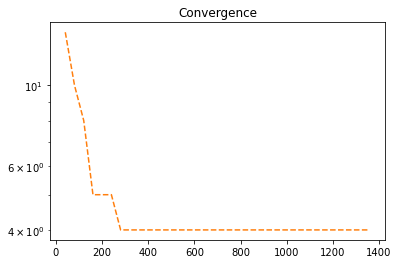

In [81]:
import matplotlib.pyplot as plt

n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, opt, "--")
plt.yscale("log")
plt.show()

In [82]:
X = res.X
F = res.F

In [83]:
F

array([[-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ],
       [-0.12270336,  4.        ]])

In [122]:
X

array([2, 9, 0, 2, 2])

In [124]:
sorted_list = [(x, f) for f, x in sorted(zip(F.tolist(), X.tolist()), key=lambda pair: pair[0])]
print(sorted_list)

[([2, 9, 0, 2, 2], [-0.12270336479573456, 4.0]), ([2, 1, 1, 2, 2], [-0.12270336479573456, 4.0]), ([2, 8, 0, 2, 2], [-0.12270336479573456, 4.0]), ([2, 2, 1, 2, 2], [-0.12270336479573456, 4.0]), ([2, 4, 1, 2, 2], [-0.12270336479573456, 4.0]), ([2, 1, 0, 2, 2], [-0.12270336479573456, 4.0]), ([2, 9, 1, 2, 2], [-0.12270336479573456, 4.0]), ([2, 7, 1, 2, 2], [-0.12270336479573456, 4.0]), ([2, 7, 0, 2, 2], [-0.12270336479573456, 4.0]), ([2, 5, 0, 2, 2], [-0.12270336479573456, 4.0]), ([2, 4, 0, 2, 2], [-0.12270336479573456, 4.0]), ([2, 5, 1, 2, 2], [-0.12270336479573456, 4.0]), ([2, 8, 1, 2, 2], [-0.12270336479573456, 4.0]), ([2, 3, 1, 2, 2], [-0.12270336479573456, 4.0]), ([2, 6, 0, 2, 2], [-0.12270336479573456, 4.0]), ([2, 2, 0, 2, 2], [-0.12270336479573456, 4.0]), ([2, 0, 1, 2, 2], [-0.12270336479573456, 4.0]), ([2, 3, 0, 2, 2], [-0.12270336479573456, 4.0]), ([2, 0, 0, 2, 2], [-0.12270336479573456, 4.0]), ([2, 6, 1, 2, 2], [-0.12270336479573456, 4.0])]


In [118]:
list_b = [1, 2, 3, 4]
list_a = [[1,2], [1, 2], [1, 2], [1, 2]]

sorted_list = sorted(list_a, key=lambda x: (x[0], x[1]))
print(sorted_list)
sorted_zip = [(x,y) for y, x in sorted(zip(list_a, list_b), key=lambda pair: pair[0])]
print(sorted_zip[0])

[[1, 2], [1, 2], [1, 2], [1, 2]]
(1, [1, 2])


In [299]:
def experiment_GA(providers_no, microcells_no, number_of_category, iterations):
    energy_usage_record_list = []
    fulfillment_ratio_record_list = []
    cost_record_list = []
    time_record_list = []
    
    for i in range(iterations):
        start_time = time.time()
        
#         random.seed(i)
        
        providers_probabilistic_patterns, providers_availability, microcell_preference_dict, microcell_location_request_dict, request_sum = initialise_all_stuff(providers_no, microcells_no, number_of_category)
        provider_probabilistic_pattern_timestep_1 = [sorted(providers_probabilistic_patterns[i][0].items(), key=lambda item: item[1], reverse=True) for i in range(len(providers_probabilistic_patterns))]
        
#         print(providers_probabilistic_patterns)
#         print("providers")
#         print(provider_probabilistic_pattern_timestep_1)
#         print(microcell_location_request_dict)
#         print("microcells")
        
#         print(i)
#         print()
        
        problem = ServiceAllocationProblem(provider_probabilistic_pattern_timestep_1, providers_availability, microcell_location_request_dict, providers_no, microcells_no)

        algorithm = NSGA2(
                pop_size=40,
                n_offsprings=40,
                sampling=get_sampling("int_random"),
                crossover=get_crossover("int_sbx", prob=0.5, eta=15),
                mutation=get_mutation("int_pm", eta=20),
                eliminate_duplicates=True
                )
        res = minimize(problem,
                       algorithm,
                       save_history=True)
        
        
        

        EU, FR, C = evaluate_EU_FR_C_GA(res, microcell_location_request_dict, providers_availability)
        energy_usage_record_list.append(EU)
        fulfillment_ratio_record_list.append(FR)
        cost_record_list.append(C)
        time_record_list.append(time.time()-start_time)
        
    return np.mean(energy_usage_record_list), np.mean(fulfillment_ratio_record_list), np.mean(cost_record_list), np.mean(time_record_list)

In [300]:
def evaluate_EU_FR_C_GA(res, microcell_location_request_dict, providers_availability):
    # Pick the best candidate in terms of FR and C
    X = res.X # chromosomes
    F = res.F # fitness score
    sorted_list = [(x, f) for f, x in sorted(zip(F.tolist(), X.tolist()), key=lambda pair: pair[0])]
    
    best_chromosome_fitness = sorted_list[0]
#     print(best_chromosome_fitness)
    FR, C = best_chromosome_fitness[1][0] * -1, best_chromosome_fitness[1][1]
    
    # Evaluate the EU
    total_fulfilled_energy = 0
    total_available_energy = np.sum(providers_availability)
    microcell_loc_req_dict = copy.deepcopy(microcell_location_request_dict)

    # Maxmize the energy fulfillment across the microcell
    x = best_chromosome_fitness[0]
    for i in range(len(x)):
#         print(x[i])
        request = microcell_loc_req_dict[x[i]]['request']
        provider_availability = providers_availability[i]

        if request > provider_availability:
            total_fulfilled_energy += provider_availability
            microcell_loc_req_dict[x[i]]['request'] = (request - provider_availability)
        else:
            total_fulfilled_energy += request
            microcell_loc_req_dict[x[i]]['request'] = 0
            
    EU = total_fulfilled_energy / total_available_energy
    
    return EU, FR, C

In [274]:
def test_all_combinations_genetic(number_of_iterations):
    levels = [7]
    no_of_variants = [5, 10, 15, 20, 25, 30]
    
    result_dict_fixed_providers_GA = {}
    result_dict_fixed_microcells_GA = {}
    
    for level in levels:    
        for variant_number in no_of_variants:
            # Fixed the number of providers
            
            start_time = time.time()
            
            EU_providers, FR_providers, C_providers, T_providers = experiment_GA(15, variant_number, level, number_of_iterations)
            EU_tag = '{}_{}_{}_{}_EU'.format(level, 15, variant_number, 'GA')
            FR_tag = '{}_{}_{}_{}_FR'.format(level, 15, variant_number, 'GA')
            C_tag = '{}_{}_{}_{}_C'.format(level, 15, variant_number, 'GA')
            T_tag = '{}_{}_{}_{}_T'.format(level, 15, variant_number, 'GA')
            result_dict_fixed_providers_GA[EU_tag] = EU_providers
            result_dict_fixed_providers_GA[FR_tag] = FR_providers
            result_dict_fixed_providers_GA[C_tag] = C_providers
            result_dict_fixed_providers_GA[T_tag] = T_providers
            
            EU_microcells, FR_microcells, C_microcells, T_microcells = experiment_GA(variant_number, 15, level, number_of_iterations)

            EU_tag = '{}_{}_{}_{}_EU'.format(level, variant_number, 15, 'GA')
            FR_tag = '{}_{}_{}_{}_FR'.format(level, variant_number, 15, 'GA')
            C_tag = '{}_{}_{}_{}_C'.format(level, variant_number, 15, 'GA')
            T_tag = '{}_{}_{}_{}_T'.format(level, variant_number, 15, 'GA')
            result_dict_fixed_microcells_GA[EU_tag] = EU_microcells
            result_dict_fixed_microcells_GA[FR_tag] = FR_microcells
            result_dict_fixed_microcells_GA[C_tag] = C_microcells
            result_dict_fixed_microcells_GA[T_tag] = T_microcells
            
            print("Finished 1 setup")
            print("Time taken: {:.2f}".format((time.time()-start_time)/60))

    return result_dict_fixed_providers_GA, result_dict_fixed_microcells_GA

In [302]:
result_dict_fixed_providers_GA, result_dict_fixed_microcells_GA = test_all_combinations_genetic(1000)

KeyboardInterrupt: 

In [301]:
A, B = test_all_combinations_genetic(3)

Finished 1 setup
Time taken: 0.19
Finished 1 setup
Time taken: 0.19
Finished 1 setup
Time taken: 0.17
Finished 1 setup
Time taken: 0.25
Finished 1 setup
Time taken: 0.22
Finished 1 setup
Time taken: 0.35


In [298]:
A

{'7_15_5_GA_EU': 1.0,
 '7_15_5_GA_FR': 0.7428588931231161,
 '7_15_5_GA_C': 220.45999999999998,
 '7_15_5_GA_T': 1.265117073059082,
 '7_15_10_GA_EU': 1.0,
 '7_15_10_GA_FR': 0.35872829521189403,
 '7_15_10_GA_C': 198.294,
 '7_15_10_GA_T': 1.3318687915802,
 '7_15_15_GA_EU': 1.0,
 '7_15_15_GA_FR': 0.2373764975889142,
 '7_15_15_GA_C': 160.534,
 '7_15_15_GA_T': 0.9496792793273926,
 '7_15_20_GA_EU': 1.0,
 '7_15_20_GA_FR': 0.18401993864972102,
 '7_15_20_GA_C': 164.36399999999998,
 '7_15_20_GA_T': 1.4513973712921142,
 '7_15_25_GA_EU': 1.0,
 '7_15_25_GA_FR': 0.1409712613566915,
 '7_15_25_GA_C': 124.37600000000002,
 '7_15_25_GA_T': 0.809242057800293,
 '7_15_30_GA_EU': 1.0,
 '7_15_30_GA_FR': 0.11829277359442122,
 '7_15_30_GA_C': 136.08200000000002,
 '7_15_30_GA_T': 1.5556956291198731}

In [250]:
result_dict_fixed_microcells_GA

{'7_5_15_GA_EU': 1.0,
 '7_5_15_GA_FR': 0.08486527323092423,
 '7_5_15_GA_C': 37.13999999999999,
 '7_5_15_GA_T': 0.5362346863746643,
 '7_10_15_GA_EU': 1.0,
 '7_10_15_GA_FR': 0.14838997485603048,
 '7_10_15_GA_C': 128.41000000000003,
 '7_10_15_GA_T': 0.6909444868564606,
 '7_15_15_GA_EU': 1.0,
 '7_15_15_GA_FR': 0.21374532133471377,
 '7_15_15_GA_C': 152.81999999999988,
 '7_15_15_GA_T': 0.7858503150939942,
 '7_20_15_GA_EU': 1.0,
 '7_20_15_GA_FR': 0.3067209263299212,
 '7_20_15_GA_C': 316.65,
 '7_20_15_GA_T': 0.745065896987915,
 '7_25_15_GA_EU': 1.0,
 '7_25_15_GA_FR': 0.37189079878665326,
 '7_25_15_GA_C': 443.27999999999975,
 '7_25_15_GA_T': 1.211060049533844,
 '7_30_15_GA_EU': 1.0,
 '7_30_15_GA_FR': 0.49425184522478194,
 '7_30_15_GA_C': 674.2400000000004,
 '7_30_15_GA_T': 1.759933979511261}

In [249]:
counter = 1

for i in result_dict_fixed_microcells_GA.values():
    if counter % 4 == 0:
        print(i)
    else:
        print(i ,end='\t')
    counter += 1

1.0	0.08486527323092423	37.13999999999999	0.5362346863746643
1.0	0.14838997485603048	128.41000000000003	0.6909444868564606
1.0	0.21374532133471377	152.81999999999988	0.7858503150939942
1.0	0.3067209263299212	316.65	0.745065896987915
1.0	0.37189079878665326	443.27999999999975	1.211060049533844
1.0	0.49425184522478194	674.2400000000004	1.759933979511261


In [154]:
result_dict_fixed_microcells_GA

{'7_5_15_GA_EU': 1.0,
 '7_5_15_GA_FR': 0.0848652732309242,
 '7_5_15_GA_C': 37.14,
 '7_10_15_GA_EU': 1.0,
 '7_10_15_GA_FR': 0.1483899748560305,
 '7_10_15_GA_C': 128.41,
 '7_15_15_GA_EU': 1.0,
 '7_15_15_GA_FR': 0.21374532133471372,
 '7_15_15_GA_C': 152.8199999999999,
 '7_20_15_GA_EU': 1.0,
 '7_20_15_GA_FR': 0.30672092632992115,
 '7_20_15_GA_C': 316.65000000000003,
 '7_25_15_GA_EU': 1.0,
 '7_25_15_GA_FR': 0.3718907987866532,
 '7_25_15_GA_C': 443.28,
 '7_30_15_GA_EU': 1.0,
 '7_30_15_GA_FR': 0.49425184522478194,
 '7_30_15_GA_C': 674.2400000000004}

## Experiment on responsive rate

Start with GA

In [233]:
def experiment_GA_response_rate(providers_no, microcells_no, number_of_category, iterations, number_of_respondents):
    algorithm = NSGA2(
                pop_size=40,
                n_offsprings=40,
                sampling=get_sampling("int_random"),
                crossover=get_crossover("int_sbx", prob=0.5, eta=15),
                mutation=get_mutation("int_pm", eta=20),
                eliminate_duplicates=True
                )
    
    energy_usage_record_list = []
    fulfillment_ratio_record_list = []
    cost_record_list = []
    time_record_list = []
    
    for i in range(iterations):
        start_time = time.time()
        
        providers_probabilistic_patterns, providers_availability, microcell_preference_dict, microcell_location_request_dict, request_sum = initialise_all_stuff(providers_no, microcells_no, number_of_category)
        provider_probabilistic_pattern_timestep_1 = [sorted(providers_probabilistic_patterns[i][0].items(), key=lambda item: item[1], reverse=True) for i in range(len(providers_probabilistic_patterns))]
            
        problem = ServiceAllocationProblem(provider_probabilistic_pattern_timestep_1, providers_availability, microcell_location_request_dict, providers_no, microcells_no)

        res = minimize(problem,
                       algorithm,
                       seed=1,
                       save_history=True)

        EU, FR, C = evaluate_EU_FR_C_GA_response_rate(res, provider_probabilistic_pattern_timestep_1, microcell_location_request_dict, providers_availability, number_of_respondents, providers_no)
        energy_usage_record_list.append(EU)
        fulfillment_ratio_record_list.append(FR)
        cost_record_list.append(C)
        time_record_list.append(time.time() - start_time)
        
    return np.mean(energy_usage_record_list), np.mean(fulfillment_ratio_record_list), np.mean(cost_record_list), np.mean(time_record_list)

In [234]:
def evaluate_EU_FR_C_GA_response_rate(res, providers_probabilistic_patterns, microcell_location_request_dict, providers_availability, number_of_respondents, providers_no):
    # Pick the best candidate in terms of FR and C
    X = res.X # chromosomes
    F = res.F # fitness score
    sorted_list = [(x, f) for f, x in sorted(zip(F.tolist(), X.tolist()), key=lambda pair: pair[0])]
    
    best_chromosome_fitness = sorted_list[0]
#     print(best_chromosome_fitness)
#     FR, C = best_chromosome_fitness[1][0] * -1, best_chromosome_fitness[1][1]
    
    # Initialise variables
    total_fulfilled_energy = 0
    total_available_energy = np.sum(providers_availability)
    total_demand = 0
    microcell_loc_req_dict = copy.deepcopy(microcell_location_request_dict)
    
    for i in range(len(microcell_location_request_dict)):
            total_demand += microcell_location_request_dict[i]['request']
            
    FR = 0
    C = 0
    respondents = random.sample(range(0, providers_no), number_of_respondents)

    # Maxmize the energy fulfillment across the microcell
    x = best_chromosome_fitness[0]
    for i in range(len(respondents)):
#         print(x[i])
        request = microcell_loc_req_dict[x[respondents[i]]]['request']
        loc_category = microcell_loc_req_dict[x[respondents[i]]]['category']
        provider_availability = providers_availability[respondents[i]]

        if request > provider_availability:
            total_fulfilled_energy += provider_availability
            microcell_loc_req_dict[x[respondents[i]]]['request'] = (request - provider_availability)
        else:
            total_fulfilled_energy += request
            microcell_loc_req_dict[x[respondents[i]]]['request'] = 0
            
        provider_preferences = providers_probabilistic_patterns[respondents[i]]
        preference_index = len(provider_preferences)+1
        for k in range(len(provider_preferences)):
            if loc_category == provider_preferences[k][0]:
                preference_index = k+1

            C += ((provider_availability / 100) * preference_index)
            
    EU = total_fulfilled_energy / total_available_energy
    FR = total_fulfilled_energy / total_demand
    
    return EU, FR, C

In [235]:
def test_all_combinations_genetic_response_rate(number_of_iterations):
    number_of_respondents_options = [3, 6, 9, 12, 15]   
    
    result_dict_GA_response_rate = {}
    
    level = 7
    variant_number = 15 # microcell_number
    
    for number_of_respondents in number_of_respondents_options: 
            # Fixed the number of providers
            start_time = time.time()
            
            EU, FR, C, T = experiment_GA_response_rate(15, variant_number, level, number_of_iterations, number_of_respondents) # providers_no, microcells_no
            EU_tag = '{}_{}_{}_{}_{}_EU'.format(level, 15, variant_number, number_of_respondents, 'GA')
            FR_tag = '{}_{}_{}_{}_{}_FR'.format(level, 15, variant_number, number_of_respondents, 'GA')
            C_tag = '{}_{}_{}_{}_{}_C'.format(level, 15, variant_number, number_of_respondents, 'GA')
            T_tag = '{}_{}_{}_{}_{}_T'.format(level, 15, variant_number, number_of_respondents, 'GA')
            result_dict_GA_response_rate[EU_tag] = EU
            result_dict_GA_response_rate[FR_tag] = FR
            result_dict_GA_response_rate[C_tag] = C
            result_dict_GA_response_rate[T_tag] = T
            print("Finished 1 setup")
            print("Time taken: {:.2f}".format((time.time()-start_time)/60))

    return result_dict_GA_response_rate

In [244]:
result_dict_GA_response_rate = test_all_combinations_genetic_response_rate(1000)

Finished 1 setup
Time taken: 11.60
Finished 1 setup
Time taken: 13.70
Finished 1 setup
Time taken: 11.35
Finished 1 setup
Time taken: 14.05
Finished 1 setup
Time taken: 14.47


In [245]:
result_dict_GA_response_rate

{'7_15_15_3_GA_EU': 0.2022286871329567,
 '7_15_15_3_GA_FR': 0.043388925134164355,
 '7_15_15_3_GA_C': 27.88662999999999,
 '7_15_15_3_GA_T': 0.6960924851894379,
 '7_15_15_6_GA_EU': 0.4263825734375813,
 '7_15_15_6_GA_FR': 0.09840335140863536,
 '7_15_15_6_GA_C': 123.53370999999993,
 '7_15_15_6_GA_T': 0.8217190420627594,
 '7_15_15_9_GA_EU': 0.6317925712096535,
 '7_15_15_9_GA_FR': 0.13834311267766422,
 '7_15_15_9_GA_C': 121.84037999999998,
 '7_15_15_9_GA_T': 0.6812380146980286,
 '7_15_15_12_GA_EU': 0.7691668542612022,
 '7_15_15_12_GA_FR': 0.17066907597583258,
 '7_15_15_12_GA_C': 170.98393999999993,
 '7_15_15_12_GA_T': 0.8430018594264984,
 '7_15_15_15_GA_EU': 1.0,
 '7_15_15_15_GA_FR': 0.2410831122158941,
 '7_15_15_15_GA_C': 367.39721999999995,
 '7_15_15_15_GA_T': 0.8682410967350006}

In [198]:
counter = 1

for i in result_dict_GA_response_rate.values():
    if counter % 3 == 0:
        print(i)
    else:
        print(i ,end='\t')
    counter += 1

0.20222599509526504	0.043388513376775815	27.89
0.4263620386643234	0.09840587352452035	123.58999999999997
0.631859756097561	0.13835113484646194	121.76999999999998
0.7691435053885423	0.1706662191642893	170.97
1.0	0.2411023232822541	367.53000000000003


Now with all other methods

In [238]:
def experiment_response_rate(providers_no, microcells_no, mode, number_of_category, iterations, number_of_respondents):
    energy_usage_record_list = []
    fulfillment_ratio_record_list = []
    cost_record_list = []
    time_record_list = []
    
    for i in range(iterations):
        start_time = time.time()
        providers_probabilistic_patterns, providers_availability, microcell_preference_dict, microcell_location_request_dict, request_sum = initialise_all_stuff(providers_no, microcells_no, number_of_category)
        providers_info = sorted(zip(providers_probabilistic_patterns, providers_availability), key=lambda pair: pair[1], reverse=True)
        
        total_available_energy = np.sum(providers_availability)
        fulfillment_energy = 0
        cost = 0
        
        supplied_providers = 0
        
        respondents = random.sample(range(0, providers_no), number_of_respondents)
        
        for j in range(providers_no):
            supplying = False
            provider_probabilistic_pattern = sorted(providers_probabilistic_patterns[j][0].items(), key=lambda item: item[1], reverse=True)   
            provider_availability = providers_availability[j]
            
            if mode == 'random':
                loc_key = random.choice(list(microcell_location_request_dict))
                request = microcell_location_request_dict[loc_key]['request']
                
                if request != 0:
                    supplied_providers += 1
                    supplying = True
            elif mode == 'preference':
                loc_key = None
                probabilistic_pattern = provider_probabilistic_pattern[0]
                if probabilistic_pattern[0] in microcell_preference_dict:
                    loc_key = random.choice(microcell_preference_dict[probabilistic_pattern[0]])
                    
                if loc_key is not None:    
                    request = microcell_location_request_dict[loc_key]['request']
                    if request != 0:
                        supplied_providers += 1
                        supplying = True
                
            elif mode == 'demanding':
                loc_key = sorted(microcell_location_request_dict.items(), key=lambda item: item[1]['request'], reverse=True)[0][0]
                
                request = microcell_location_request_dict[loc_key]['request']
                
                if request != 0:
                    supplied_providers += 1
                    supplying = True
                
            elif mode == 'preference+demanding':
                provider_probabilistic_pattern = sorted(providers_info[j][0][0].items(), key=lambda item: item[1], reverse=True)
                provider_availability = providers_info[j][1]
                
                loc_key = None
                for p in provider_probabilistic_pattern:
                    preferences_locations = {}
                    if p[0] in microcell_preference_dict: # If category in microcell_preference_dict
                        for loc_id in microcell_preference_dict[p[0]]: # Add locations into the preferences_locations
                            preferences_locations[loc_id] = microcell_location_request_dict[loc_id]
                            
                        for item in sorted(preferences_locations.items(), key=lambda item: item[1]['request'], reverse=True):
                            loc_key = item[0]
                            request = microcell_location_request_dict[loc_key]['request']
                            
                            if request != 0:
                                break
                        
                        if loc_key is not None:
                            break
                            
                if loc_key is None:
                    loc_key = sorted(microcell_location_request_dict.items(), key=lambda item: item[1]['request'], reverse=True)[0][0]
                    
                request = microcell_location_request_dict[loc_key]['request']
                            
                if request != 0:
                    supplied_providers += 1
                    supplying = True
                    
            elif mode == 'demanding+preference':
                provider_probabilistic_pattern = sorted(providers_info[j][0][0].items(), key=lambda item: item[1], reverse=True)
                provider_availability = providers_info[j][1]
                
                loc_key = None
                
                ordered_demand_list = sorted(microcell_location_request_dict.items(), key=lambda item: item[1]['request'], reverse=True)
                provider_preferences = [p[0] for p in provider_probabilistic_pattern] # all provider's preference in the form of [(category, probability)]
                
                for i in ordered_demand_list:
                    if (i[1]['category'] in provider_preferences):
                        loc_key = i[0]
                        break
                
                if loc_key is None:
                    loc_key = sorted(microcell_location_request_dict.items(), key=lambda item: item[1]['request'], reverse=True)[0][0]
                    
                request = microcell_location_request_dict[loc_key]['request']
                
                if request != 0:
                    supplied_providers += 1
                    supplying = True
                
                
            if loc_key is not None:
                loc_category = microcell_location_request_dict[loc_key]['category']

                if j in respondents:
                    if request > provider_availability:
                        fulfillment_energy += provider_availability
                        microcell_location_request_dict[loc_key]['request'] = (request - provider_availability)
                    else:
                        fulfillment_energy += request
                        microcell_location_request_dict[loc_key]['request'] = 0
                
                
            if supplying and j in respondents:
                preference_index = len(provider_probabilistic_pattern)+1
                for k in range(len(provider_probabilistic_pattern)):
                    if loc_category == provider_probabilistic_pattern[k][0]:
                        preference_index = k+1

                cost += ((provider_availability / 100) * preference_index)
        energy_usage_record_list.append(fulfillment_energy / total_available_energy)
        fulfillment_ratio_record_list.append(fulfillment_energy / request_sum)
    
        if supplied_providers != 0:
            cost_record_list.append(cost)
            
        time_record_list.append(time.time()-start_time)
    
    return np.mean(energy_usage_record_list), np.mean(fulfillment_ratio_record_list), np.mean(cost_record_list), np.mean(time_record_list)

In [239]:
def test_all_combinations_response_rate(number_of_iterations):
    level = 7
    variant_number = 15
    modes = ['preference', 'demanding', 'demanding+preference']
    
    number_of_respondents_options = [3, 6, 9, 12, 15]   
    
    result_dict_response_rate = {}
    
    for number_of_respondents in number_of_respondents_options:
        for mode in modes:
            start_time = time.time()

            EU, FR, C, T = experiment_response_rate(15, variant_number, mode, level, number_of_iterations, number_of_respondents)

            EU_tag = '{}_{}_{}_{}_{}_EU'.format(level, 15, variant_number, number_of_respondents, mode)
            FR_tag = '{}_{}_{}_{}_{}_FR'.format(level, 15, variant_number, number_of_respondents, mode)
            C_tag = '{}_{}_{}_{}_{}_C'.format(level, 15, variant_number, number_of_respondents, mode)
            T_tag = '{}_{}_{}_{}_{}_T'.format(level, 15, variant_number, number_of_respondents, mode)
            result_dict_response_rate[EU_tag] = EU
            result_dict_response_rate[FR_tag] = FR
            result_dict_response_rate[C_tag] = C
            result_dict_response_rate[T_tag] = T

            print("Finished 1 setup")
            print("Time taken: {:.2f}".format((time.time()-start_time)/60))

    return result_dict_response_rate

In [240]:
result_dict_response_rate = test_all_combinations_response_rate(1000)

Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00


In [241]:
result_dict_response_rate

{'7_15_15_3_preference_EU': 0.17669312505354304,
 '7_15_15_3_preference_FR': 0.04125158063633559,
 '7_15_15_3_preference_C': 9.299119999999998,
 '7_15_15_3_preference_T': 0.00014693188667297364,
 '7_15_15_3_demanding_EU': 0.19966939029111336,
 '7_15_15_3_demanding_FR': 0.04665192641135441,
 '7_15_15_3_demanding_C': 28.64479,
 '7_15_15_3_demanding_T': 0.00016199898719787597,
 '7_15_15_3_demanding+preference_EU': 0.19941411605532536,
 '7_15_15_3_demanding+preference_FR': 0.04672760512674261,
 '7_15_15_3_demanding+preference_C': 17.49536,
 '7_15_15_3_demanding+preference_T': 0.00018399381637573242,
 '7_15_15_6_preference_EU': 0.3587764829226401,
 '7_15_15_6_preference_FR': 0.08361489162176439,
 '7_15_15_6_preference_C': 18.875709999999998,
 '7_15_15_6_preference_T': 0.00013097023963928221,
 '7_15_15_6_demanding_EU': 0.3995298937670497,
 '7_15_15_6_demanding_FR': 0.09359122511470554,
 '7_15_15_6_demanding_C': 56.22798999999999,
 '7_15_15_6_demanding_T': 0.00018300795555114746,
 '7_15_15_6_